# Capstone Project - The Neighborhoods in Toronto

## Applied Data Science Capstone by IBM/Coursera


## Introduction: Business Problem

In this project we will try to analyze the neighborhood in Toronto. Specifically, this report will be targeted to the venue such as surrounding place nearby each neighborhood in North York.

Since there are lots of neighborhood in Toronto we will try to detect locations that are mostly popular and centered. We would also prefer locations as close to city center as possible, assuming that first conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be analyzed.

## Data

Based on definition of our problem, factors that will influence our decission are:

- number of existing venues in the neighborhood (any type of restaurant)
- number of and nearby restaurants in the neighborhood, if any
- distance of neighborhood from city center
- Latitude,	Longitude of the nearby neighborhood
We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:

- centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using wikipeida data
- number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API
- coordinate of Berlin center will be obtained using Google Maps API geocoding of well known North York location

## Segmenting and Clustering Neighborhoods in Toronto

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Download and Explore Dataset

In [2]:
df = pd.read_csv("toronto_geodata.csv")
df.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,Parkview Hill / Woodbine Gardens,43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [10]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

In [16]:
df_borough = df['Borough'].value_counts()
df_borough

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East Toronto         5
East York            5
Mississauga          1
Name: Borough, dtype: int64

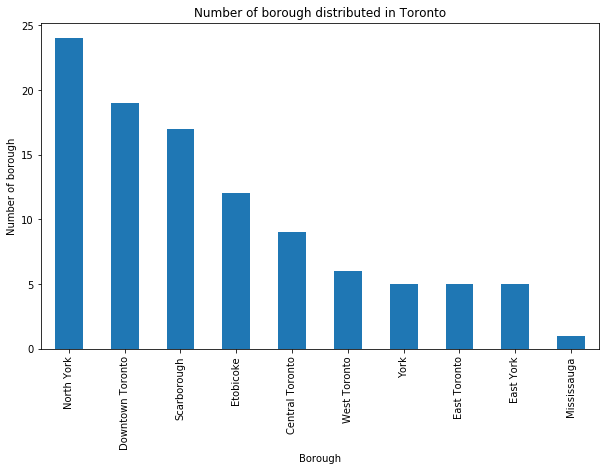

In [13]:
df_borough.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Number of borough') # add y-label to the plot
plt.title('Number of borough distributed in Toronto') # add title to the plot

plt.show()

In [14]:
address = 'Toronto, T.O'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [15]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [21]:
northyork_data = df[df['Borough'] == 'North York'].reset_index(drop=True)
northyork_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
3,M3B,North York,Don Mills,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073


Since we notice the amount of North York neighborhood in Toronto occupy the most proportion, we could choose the most popular borough North York as the focus of our analysis today.

In [26]:
address = 'North York, Toronto'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of North York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of North York are 43.7543263, -79.44911696639593.


We make the map include all the neighborhood in North York borough.

In [27]:
map_northyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(northyork_data['Latitude'], northyork_data['Longitude'], northyork_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_northyork)  
    
map_northyork

In [79]:
# @hidden_cell
CLIENT_ID = '5ZN4UZWO11UW3ZJISX4HNJG135G55DQDXNTKATFBALP41VPS' # Foursquare ID
CLIENT_SECRET = 'TU2ZS1GY5AFRS5DKZMELHVNOGM1E3EC2UQ3SILRISPLE3FMJ' # Foursquare Secret
VERSION = '20200413'
LIMIT = 100
radius = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5ZN4UZWO11UW3ZJISX4HNJG135G55DQDXNTKATFBALP41VPS
CLIENT_SECRET:TU2ZS1GY5AFRS5DKZMELHVNOGM1E3EC2UQ3SILRISPLE3FMJ


In [80]:
northyork_data.loc[0, 'Neighborhood']

'Parkwoods'

In [81]:
neighborhood_latitude = northyork_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = northyork_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = northyork_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [82]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=5ZN4UZWO11UW3ZJISX4HNJG135G55DQDXNTKATFBALP41VPS&client_secret=TU2ZS1GY5AFRS5DKZMELHVNOGM1E3EC2UQ3SILRISPLE3FMJ&ll=43.7532586,-79.3296565&v=20200413&radius=1000&limit=100'

In [83]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e95231c1835dd001bab4758'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 29,
  'suggestedBounds': {'ne': {'lat': 43.762258609000014,
    'lng': -79.31721997969855},
   'sw': {'lat': 43.74425859099999, 'lng': -79.34209302030145}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b8991cbf964a520814232e3',
       'name': "Allwyn's Bakery",
       'location': {'address': '81 Underhill drive',
        'lat': 43.75984035203157,
        'lng': -79.32471879917513,
        'labeledLatLngs': [{'label': 'display'

In [84]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [85]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

D:\ProgramFiles\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Allwyn's Bakery,Caribbean Restaurant,43.759840,-79.324719
1,Brookbanks Park,Park,43.751976,-79.332140
2,Tim Hortons,Café,43.760668,-79.326368
3,A&W,Fast Food Restaurant,43.760643,-79.326865
4,Bruno's valu-mart,Grocery Store,43.746143,-79.324630


## 2. Explore neighborhood in North York

In [86]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [89]:
northyork_venues = getNearbyVenues(names=northyork_data['Neighborhood'],
                                   latitudes=northyork_data['Latitude'],
                                   longitudes=northyork_data['Longitude']
                                  )

Parkwoods
Victoria Village
Lawrence Manor / Lawrence Heights
Don Mills
Glencairn
Don Mills
Hillcrest Village
Bathurst Manor / Wilson Heights / Downsview North
Fairview / Henry Farm / Oriole
Northwood Park / York University
Bayview Village
Downsview
York Mills / Silver Hills
Downsview
North Park / Maple Leaf Park / Upwood Park
Humber Summit
Willowdale / Newtonbrook
Downsview
Bedford Park / Lawrence Manor East
Humberlea / Emery
Willowdale
Downsview
York Mills West
Willowdale


In [136]:
print(northyork_venues.shape)
northyork_venues.head()

(248, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


## 3. Analyze each neighborhood

In [90]:
# one hot encoding
northyork_onehot = pd.get_dummies(northyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
northyork_onehot['Neighborhood'] = northyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [northyork_onehot.columns[-1]] + list(northyork_onehot.columns[:-1])
northyork_onehot = northyork_onehot[fixed_columns]

northyork_onehot.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Electronics Store,Empanada Restaurant,Event Space,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hobby Shop,Hockey Arena,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Luggage Store,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Other Repair Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Smoke Shop,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Video Store,Vietnamese Restaurant,Women's Store
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
northyork_grouped = northyork_onehot.groupby('Neighborhood').mean().reset_index()
northyork_grouped

,Neighborhood,Accessories Store,Airport,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Electronics Store,Empanada Restaurant,Event Space,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hobby Shop,Hockey Arena,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Luggage Store,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Other Repair Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Smoke Shop,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Video Store,Vietnamese Restaurant,Women's Store
0,Bathurst Manor / Wilson Heights / Downsview North,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.100000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.05,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.050000,0.000000,0.000000,0.100000,0.00,0.000000,0.00,0.000000,0.000000,0.050000,0.000000,0.000000,0.05,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.0,0.00000,0.000000,0.05,0.000000,0.000000,0.05,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.050000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.050000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.050000,0.000000,0.050000,0.00000,0.050000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.050000,0.000000,0.00,0.000000,0.00000,0.000000,0.05,0.000000,0.00000
1,Bayview Village,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.250000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.0,0.00000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.00,0.000000,0.00000
2,Bedford Park / Lawrence Manor East,0.0000,0.000000,0.040000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.04,0.00,0.000000,0.000000,0.000000,0.04,0.0,0.040000,0.000000,0.000000,0.000000,0.000000,0.080000,0.04,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.040000,0.0,0.00000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.04,0.040000,0.000000,0.000000,0.04,0.00,0.000000,0.000000,0.04,0.000000,0.080000,0.000000,0.040000,0.000000,0.040000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.0400

In [92]:
num_top_venues = 5

for hood in northyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = northyork_grouped[northyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst Manor / Wilson Heights / Downsview North----
                venue  freq
0                Bank  0.10
1         Coffee Shop  0.10
2      Ice Cream Shop  0.05
3  Chinese Restaurant  0.05
4      Sandwich Place  0.05


----Bayview Village----
                 venue  freq
0   Chinese Restaurant  0.25
1                 Bank  0.25
2  Japanese Restaurant  0.25
3                 Café  0.25
4    Accessories Store  0.00


----Bedford Park / Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1         Coffee Shop  0.08
2          Restaurant  0.08
3      Sandwich Place  0.08
4       Grocery Store  0.04


----Don Mills----
                 venue  freq
0           Restaurant  0.07
1          Coffee Shop  0.07
2  Japanese Restaurant  0.07
3     Asian Restaurant  0.07
4                  Gym  0.07


----Downsview----
                  venue  freq
0         Grocery Store  0.18
1                  Park  0.12
2         Shopping Mall  0.06
3  Gym / Fitness Center  0.

In [93]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [95]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = northyork_grouped['Neighborhood']

for ind in np.arange(northyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(northyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bathurst Manor / Wilson Heights / Downsview North,Coffee Shop,Bank,Fried Chicken Joint,Shopping Mall,Chinese Restaurant,Pharmacy,Pizza Place,Deli / Bodega,Bridal Shop,Diner
1,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store,Electronics Store,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
2,Bedford Park / Lawrence Manor East,Sandwich Place,Coffee Shop,Italian Restaurant,Restaurant,Grocery Store,Liquor Store,Café,Juice Bar,Pharmacy,Pizza Place
3,Don Mills,Coffee Shop,Asian Restaurant,Restaurant,Gym,Beer Store,Japanese Restaurant,Chinese Restaurant,Smoke Shop,Discount Store,Café
4,Downsview,Grocery Store,Park,Gym / Fitness Center,Liquor Store,Korean Restaurant,Discount Store,Shopping Mall,Hotel,Baseball Field,Other Repair Shop


## 4. Cluster neighborhood

In [101]:
# set number of clusters
kclusters = 5

northyork_grouped_clustering = northyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(northyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 3, 3, 3, 3, 4, 3])

In [103]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

northyork_merged = northyork_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
northyork_merged = northyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

northyork_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Women's Store,Dog Run,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Pizza Place,Portuguese Restaurant,Hockey Arena,Coffee Shop,Women's Store,Distribution Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop
2,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,3.0,Clothing Store,Furniture / Home Store,Women's Store,Miscellaneous Shop,Arts & Crafts Store,Boutique,Coffee Shop,Event Space,Vietnamese Restaurant,Accessories Store
3,M3B,North York,Don Mills,43.745906,-79.352188,3.0,Coffee Shop,Asian Restaurant,Restaurant,Gym,Beer Store,Japanese Restaurant,Chinese Restaurant,Smoke Shop,Discount Store,Café
4,M6B,North York,Glencairn,43.709577,-79.445073,3.0,Pizza Place,Bakery,Pub,Japanese Restaurant,Women's Store,Distribution Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop


In [129]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(northyork_merged['Latitude'], northyork_merged['Longitude'], northyork_merged['Neighborhood'], northyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    try:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            fill=True,
            color=rainbow[int(cluster)-1],
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)
    except:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            fill=True,
            color=rainbow[0],
            fill_color=rainbow[0],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### cluster1

In [130]:
northyork_merged.loc[northyork_merged['Cluster Labels'] == 0, northyork_merged.columns[[1] + list(range(5, northyork_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,0.0,Park,Food & Drink Shop,Women's Store,Dog Run,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
14,North York,0.0,Park,Construction & Landscaping,Bakery,Basketball Court,Electronics Store,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
22,North York,0.0,Park,Convenience Store,Bank,Bar,Electronics Store,Concert Hall,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store


#### cluster2

In [131]:
northyork_merged.loc[northyork_merged['Cluster Labels'] == 1, northyork_merged.columns[[1] + list(range(5, northyork_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1.0,Pizza Place,Portuguese Restaurant,Hockey Arena,Coffee Shop,Women's Store,Distribution Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop


#### cluster3

In [132]:
northyork_merged.loc[northyork_merged['Cluster Labels'] == 2, northyork_merged.columns[[1] + list(range(5, northyork_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,North York,2.0,Cafeteria,Women's Store,Dog Run,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant


#### cluster4

In [133]:
northyork_merged.loc[northyork_merged['Cluster Labels'] == 3, northyork_merged.columns[[1] + list(range(5, northyork_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,North York,3.0,Clothing Store,Furniture / Home Store,Women's Store,Miscellaneous Shop,Arts & Crafts Store,Boutique,Coffee Shop,Event Space,Vietnamese Restaurant,Accessories Store
3,North York,3.0,Coffee Shop,Asian Restaurant,Restaurant,Gym,Beer Store,Japanese Restaurant,Chinese Restaurant,Smoke Shop,Discount Store,Café
4,North York,3.0,Pizza Place,Bakery,Pub,Japanese Restaurant,Women's Store,Distribution Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop
5,North York,3.0,Coffee Shop,Asian Restaurant,Restaurant,Gym,Beer Store,Japanese Restaurant,Chinese Restaurant,Smoke Shop,Discount Store,Café
6,North York,3.0,Golf Course,Pool,Fast Food Restaurant,Mediterranean Restaurant,Dog Run,Discount Store,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store
7,North York,3.0,Coffee Shop,Bank,Fried Chicken Joint,Shopping Mall,Chinese Restaurant,Pharmacy,Pizza Place,Deli / Bodega,Bridal Shop,Diner
8,North York,3.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Bakery,Food Court,Japanese Restaurant,Bank,Restaurant,Shoe Store,Women's Store
9,North York,3.0,Coffee Shop,Miscellaneous Shop,Caribbean Restaurant,Metro Station,Bar,Massage Studio,Distribution Center,Convenience Store,Cosmetics Shop,Deli / Bodega
10,North York,3.0,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store,Electronics Store,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
11,North York,3.0,Grocery Store,Park,Gym / Fitness Center,Liquor Store,Korean Restaurant,Discount Store,Shopping Mall,Hotel,Baseball Field,Other Repair Shop


#### cluster5

In [134]:
northyork_merged.loc[northyork_merged['Cluster Labels'] == 4, northyork_merged.columns[[1] + list(range(5, northyork_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,North York,4.0,Pizza Place,Empanada Restaurant,Dog Run,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
